In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine
from config import user, db_password, host, database

In [2]:
# Create the database engine
engine = create_engine(f"postgres://{user}:{db_password}@{host}:5432/{database}")

In [39]:
# Create total features table from database tables
total_table_df = pd.read_sql_query("""select * from population_density_by_state pdbs 
                                      inner join cleaned_flu_csv cfc on pdbs."﻿State" = cfc.state;""", con=engine)

total_table_df.head()

,﻿State,xx,2016 Population Density (persons/square mile),2017 Population Density (persons/square mile),2018 Population Density (persons/square mile),2019 Population Density (persons/square mile),state,2016,2017,2018,2019
0,Alabama,"50,645.39",96.03,96.25,96.51,96.81,Alabama,11546.0,26878.0,63999.0,68724.0
1,Alaska,570640.61,1.30,1.30,1.29,1.28,Alaska,1063.0,3306.0,8352.0,8249.0
2,Arizona,"113,593.91",61.10,62.01,63.01,64.08,Arizona,22366.0,22543.0,24574.0,20504.0
3,Arkansas,"52,035.35",57.46,57.68,57.84,58.00,Arkansas,2883.0,5249.0,5831.0,5939.0
4,California,"155,779.03",251.43,252.66,253.32,253.64,California,44159.0,46097.0,52153.0,52210.0


In [4]:
#Import population density by state table and check column names

# Create population density dataframe
pop_df = pd.read_sql_query("SELECT * FROM population_density_by_state", con=engine)

# Create uninsured dataframe
uni_df = pd.read_sql_query("SELECT * FROM uninsured_rates_by_state", con=engine)

# Create gdp dataframe
gdp_df = pd.read_sql_query("SELECT * FROM cleaned_gbp_csv", con=engine)

# Create pci dataframe
pci_df = pd.read_sql_query("SELECT * FROM pci_by_state_cleaned_csv", con=engine)

# Create flu dataframe
flu_df = pd.read_sql_query("SELECT * FROM flu_percentages", con=engine)

In [5]:
# Check the pop_df out
pop_df.head()

pop_df = pop_df.drop(columns="xx", axis=1)
pop_df.drop(pop_df.index[(pop_df['﻿State'] == "District Of Columbia")], axis=0, inplace=True)

# print(pop_df)

In [6]:
# Check out the uninsured dataframe
uni_df.head()

uni_df.drop(uni_df.index[(uni_df['﻿State'] == "District of Columbia")], axis=0, inplace=True)

uni_df.columns

Index(['﻿State', 'Uninsured Rate 2016', 'Uninsured Rate 2017',
       'Uninsured Rate 2018', 'Uninsured Rate 2019'],
      dtype='object')

In [7]:
# Check out the gdp dataframe
gdp_df.head()

gdp_df = gdp_df.drop(columns=["column1", "description", "gdp_2015"])

gdp_df.columns

# print(gdp_df)

Index(['state_name', 'gdp_2016', 'gdp_2017', 'gdp_2018', 'gdp_2019'], dtype='object')

In [8]:
# Checkout the pci dataframe
pci_df.head()

pci_df.drop(pci_df.index[(pci_df['column1'] == "DCPCPI")], axis=0, inplace=True)
pci_df.drop(pci_df.index[(pci_df['column1'] == "NC")])

pci_df = pci_df.rename(columns = {"2016": "pci_2016", 
                                  "2017": "pci_2017",
                                  "2018": "pci_2018",
                                  "2019": "pci_2019"})

# pci_df.drop(columns="column1", inplace=True)

pci_df = pci_df.reset_index(drop=True)

# print(pci_df)

pci_df.columns

Index(['column1', 'pci_2016', 'pci_2017', 'pci_2018', 'pci_2019'], dtype='object')

In [9]:
pci_gdp_df = pd.concat([pci_df, gdp_df], axis=1)

# print (pci_gdp_df)

In [10]:
# Check out the flu_df
flu_df.head()

flu_df.drop(flu_df.index[(flu_df["state"]) == "District of Columbia"], axis=0, inplace=True)

flu_df.columns

Index(['state', '2016_cases_percent', '2017_cases_percent',
       '2018_cases_percent', '2019_cases_percent'],
      dtype='object')

In [11]:
# Merge dataframes
flu_factors_df = pop_df.merge(uni_df, how="left")

flu_factors_df = pd.concat([flu_factors_df, gdp_df], axis=1)
 
flu_factors_df.drop(columns="state_name", inplace=True)

flu_factors_df = pd.concat([flu_factors_df, pci_df], axis=1)

flu_factors_df.drop(columns="column1", inplace=True)

flu_factors_df.head()

# print(flu_factors_df)

,﻿State,2016 Population Density (persons/square mile),2017 Population Density (persons/square mile),2018 Population Density (persons/square mile),2019 Population Density (persons/square mile),Uninsured Rate 2016,Uninsured Rate 2017,Uninsured Rate 2018,Uninsured Rate 2019,gdp_2016,gdp_2017,gdp_2018,gdp_2019,pci_2016,pci_2017,pci_2018,pci_2019
0,Alabama,96.03,96.25,96.51,96.81,9.1,9.4,10.0,9.7,191523,193693,198053,200829,39536.0,41030.0,42710.0,44145.0
1,Alaska,1.30,1.30,1.29,1.28,14.0,13.7,12.0,12.2,53289,52825,52928,53255,56302.0,57394.0,60355.0,62806.0
2,Arizona,61.10,62.01,63.01,64.08,10.0,10.1,10.0,11.3,291259,302117,314016,323597,40801.0,42590.0,44597.0,46058.0
3,Arkansas,57.46,57.68,57.84,58.00,7.9,7.9,8.0,9.1,113490,114950,116698,117447,40385.0,41657.0,43325.0,44629.0
4,California,251.43,252.66,253.32,253.64,7.3,7.2,7.0,7.7,2519133,2628314,2708966,2800505,58048.0,60549.0,63720.0,66619.0


In [12]:
# Check flu factors df columns
flu_factors_df.columns

Index(['﻿State', '2016 Population Density (persons/square mile)',
       '2017 Population Density (persons/square mile)',
       '2018 Population Density (persons/square mile)',
       '2019 Population Density (persons/square mile)', 'Uninsured Rate 2016',
       'Uninsured Rate 2017', 'Uninsured Rate 2018', 'Uninsured Rate 2019',
       'gdp_2016', 'gdp_2017', 'gdp_2018', 'gdp_2019', 'pci_2016', 'pci_2017',
       'pci_2018', 'pci_2019'],
      dtype='object')

In [13]:
# Seperate into years
# factors in 2016
flu_factors_2016_df = flu_factors_df[['﻿State', '2016 Population Density (persons/square mile)', 
                                     'Uninsured Rate 2016', 'gdp_2016', 'pci_2016']]

# flu_factors_2016_df.head()

# factors in 2017
flu_factors_2017_df = flu_factors_df[['﻿State', '2017 Population Density (persons/square mile)', 
                                     'Uninsured Rate 2017', 'gdp_2017', 'pci_2017']]

# flu_factors_2017_df.head()

# factors in 2018
flu_factors_2018_df = flu_factors_df[['﻿State', '2018 Population Density (persons/square mile)', 
                                     'Uninsured Rate 2018', 'gdp_2018', 'pci_2018']]

# flu_factors_2018_df.head()

# factors in 2019
flu_factors_2019_df = flu_factors_df[['﻿State', '2019 Population Density (persons/square mile)', 
                                     'Uninsured Rate 2019', 'gdp_2019', 'pci_2019']]

# flu_factors_2019_df.head()

In [14]:
# Designate independent and dependent variables

# Dependent variables
y_2016 = flu_df['2016_cases_percent']
y_2017 = flu_df['2017_cases_percent']
y_2018 = flu_df['2018_cases_percent']
y_2019 = flu_df['2019_cases_percent']

# Independent variables
X_2016 = flu_factors_2016_df[['2016 Population Density (persons/square mile)', 
                              'Uninsured Rate 2016', 'gdp_2016', 'pci_2016']]
X_2017 = flu_factors_2017_df[['2017 Population Density (persons/square mile)', 
                              'Uninsured Rate 2017', 'gdp_2017', 'pci_2017']]
X_2018 = flu_factors_2018_df[['2018 Population Density (persons/square mile)', 
                              'Uninsured Rate 2018', 'gdp_2018', 'pci_2018']]
X_2019 = flu_factors_2019_df[['2019 Population Density (persons/square mile)', 
                              'Uninsured Rate 2019', 'gdp_2019', 'pci_2019']]

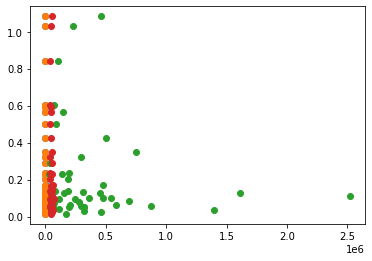

In [15]:
# visualize 2016 data

fig_2016 = plt.plot(X_2016, y_2016, 'o')

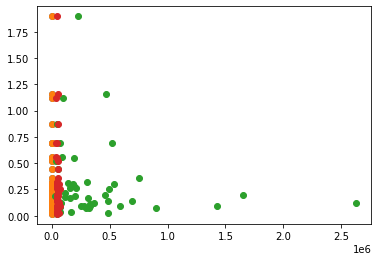

In [16]:
# visualize 2017 data

fig_2017 = plt.plot(X_2017, y_2017, 'o')

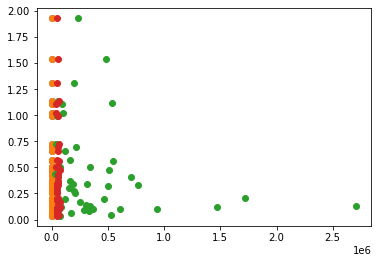

In [17]:
# visualize 2018 data

fig_2018 = plt.plot(X_2018, y_2018, 'o')

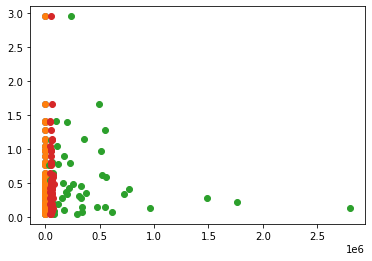

In [18]:
# visualize 2019 data

fig_2019 = plt.plot(X_2019, y_2019, 'o')

In [19]:
# Split data

# 2016
X_2016_train, X_2016_test, y_2016_train, y_2016_test = train_test_split(X_2016, y_2016, random_state=42)

# 2017
X_2017_train, X_2017_test, y_2017_train, y_2017_test = train_test_split(X_2017, y_2017, random_state=42) 

# 2018
X_2018_train, X_2018_test, y_2018_train, y_2018_test = train_test_split(X_2018, y_2018, random_state=42) 

# 2019
X_2019_train, X_2019_test, y_2019_train, y_2019_test = train_test_split(X_2019, y_2019, random_state=42) 

In [20]:
# Initiate scaler
scaler = StandardScaler()

In [21]:
# Scale data

# # training
X_2016_train_scaled = scaler.fit_transform(X_2016_train)
X_2017_train_scaled = scaler.fit_transform(X_2017_train)
X_2018_train_scaled = scaler.fit_transform(X_2018_train)
X_2019_train_scaled = scaler.fit_transform(X_2019_train)

# # testing
X_2016_test_scaled = scaler.fit_transform(X_2016_test)
X_2017_test_scaled = scaler.fit_transform(X_2017_test)
X_2018_test_scaled = scaler.fit_transform(X_2018_test)
X_2019_test_scaled = scaler.fit_transform(X_2019_test)

In [22]:
# initialize the Linear Regression model

model = LinearRegression()

In [23]:
# X_2016_train_scaled

In [24]:
# fit model

# 2016
mlr_2016 = model.fit(X_2016_train_scaled, y_2016_train)

# 2017
mlr_2017 = model.fit(X_2017_train_scaled, y_2017_train)

# 2018
mlr_2018 = model.fit(X_2018_train_scaled, y_2018_train)

# 2019
mlr_2019 = model.fit(X_2019_train_scaled, y_2019_train)

In [25]:
# create predictions

# 2016
y_2016_pred = mlr_2016.predict(X_2016_test_scaled)

# 2017
y_2017_pred = mlr_2017.predict(X_2017_test_scaled)

# 2018
y_2018_pred = mlr_2018.predict(X_2018_test_scaled)

# 2019
y_2019_pred = mlr_2019.predict(X_2019_test_scaled)

In [26]:
# Print 2016 coefficients
print("\n")
print("Coefficients: ", mlr_2016.coef_)
# Print 2016 mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_2016_test, y_2016_pred))
# Print coefficients of determination
print('Coefficinet of determination: %.2f'
      % r2_score(y_2016_test, y_2016_pred))
print("\n")

# Print 2017 coefficients
print("Coefficients: ", mlr_2017.coef_)
# Print 2017 mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_2017_test, y_2017_pred))
# Print coefficients of determination
print('Coefficinet of determination: %.2f'
      % r2_score(y_2017_test, y_2017_pred))
print("\n")

# Print 2018 coefficients
print("Coefficients: ", mlr_2018.coef_)
# Print 2018 mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_2018_test, y_2018_pred))
# Print coefficients of determination
print('Coefficinet of determination: %.2f'
      % r2_score(y_2018_test, y_2018_pred))
print("\n")

# Print 2019 coefficients
print("Coefficients: ", mlr_2019.coef_)
# Print 2019 mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_2019_test, y_2019_pred))
# Print coefficients of determination
print('Coefficinet of determination: %.2f'
      % r2_score(y_2019_test, y_2019_pred))
print("\n")



Coefficients:  [ 0.00203898  0.13270117 -0.12854761  0.05796069]
Mean squared error: 0.16
Coefficinet of determination: -0.23


Coefficients:  [ 0.00203898  0.13270117 -0.12854761  0.05796069]
Mean squared error: 0.28
Coefficinet of determination: -0.01


Coefficients:  [ 0.00203898  0.13270117 -0.12854761  0.05796069]
Mean squared error: 0.31
Coefficinet of determination: 0.07


Coefficients:  [ 0.00203898  0.13270117 -0.12854761  0.05796069]
Mean squared error: 0.63
Coefficinet of determination: -0.04




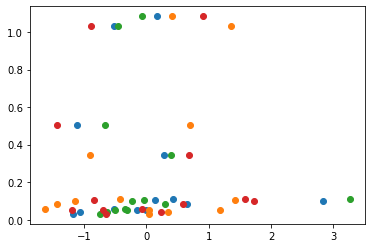

In [27]:
# Plot the linear regression 2016
lin_reg_2016 = plt.plot(X_2016_test_scaled, y_2016_test, 'o')

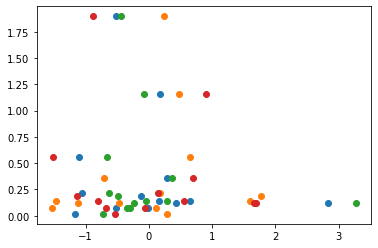

In [28]:
# Plot the linear regression 2017
lin_reg_2017 = plt.plot(X_2017_test_scaled, y_2017_test, 'o')

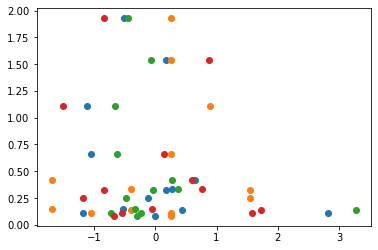

In [29]:
# Plot the linear regression 2018
lin_reg_2018 = plt.plot(X_2018_test_scaled, y_2018_test, 'o')

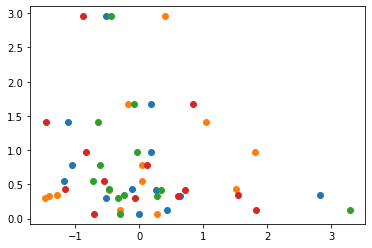

In [30]:
# Plot the linear regression 2019
lin_reg_2019 = plt.plot(X_2019_test_scaled, y_2019_test, 'o')